In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-21 12:56:59.479169: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 12:56:59.489027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761044219.502311 1124081 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761044219.506498 1124081 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 12:56:59.519520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

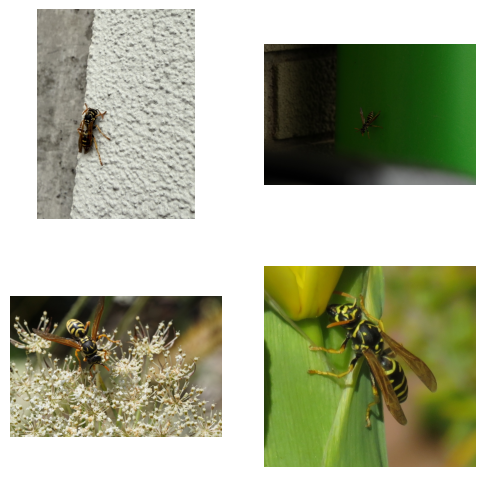

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )


- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)



Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_1124081/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761044223.399121 1124081 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761044223.400240 1124081 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45159 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 8,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761044233.351762 1124364 service.cc:148] XLA service 0x74098c0014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761044233.351797 1124364 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761044233.351803 1124364 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 12:57:13.601624: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761044234.533827 1124364 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761044236.305264 1124364 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044236.430281 1124364 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

160/344 ━━━━━━━━━━━━━━━━━━━━ 1:11 387ms/step - accuracy: 0.0387 - loss: 4.8209

E0000 00:00:1761044312.859462 1124361 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044312.983883 1124361 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044315.667443 1124361 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044315.790340 1124361 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044317.512164 1124361 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.0695 - loss: 4.5464

E0000 00:00:1761044428.457822 1124366 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044428.581723 1124366 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044431.120093 1124366 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761044431.266392 1124366 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_average_precision = 0.2741
344/344 ━━━━━━━━━━━━━━━━━━━━ 250s 660ms/step - accuracy: 0.1294 - loss: 4.0598 - val_accuracy: 0.2872 - val_loss: 3.0745 - val_average_precision: 0.2741 - learning_rate: 1.0000e-04
Epoch 2/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.3381 - loss: 2.7406
Epoch 2: val_average_precision = 0.4147
344/344 ━━━━━━━━━━━━━━━━━━━━ 201s 584ms/step - accuracy: 0.3580 - loss: 2.6043 - val_accuracy: 0.3973 - val_loss: 2.3496 - val_average_precision: 0.4147 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.4610 - loss: 2.0345
Epoch 3: val_average_precision = 0.4925
344/344 ━━━━━━━━━━━━━━━━━━━━ 197s 573ms/step - accuracy: 0.4788 - loss: 1.9844 - val_accuracy: 0.4571 - val_loss: 2.0731 - val_average_precision: 0.4925 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5596 - loss: 1.6126
Epoch 4: val_average_precision = 0.5159
344/344 ━━━━━━━━━━━━━━━━━━━━ 195s 568ms/step - accuracy: 0.5546 - loss: 1.6361 - val_accuracy: 0.4960 - val_loss: 1.8870 - val_average_precision: 0.5159 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6190 - loss: 1.3668
Epoch 5: val_average_precision = 0.5400
344/344 ━━━━━━━━━━━━━━━━━━━━ 195s 568ms/step - accuracy: 0.6042 - loss: 1.3948 - val_accuracy: 0.5172 - val_loss: 1.8131 - val_average_precision: 0.5400 - learning_rate: 1.0000e-04
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6530 - loss: 1.2149
Epoch 6: val_average_precision = 0.5557
344/344 ━━━━━━━━━━━━━━━━━━━━ 194s 566ms/step - accuracy: 0.6528 - loss: 1.2222 - val_accuracy: 0.5356 - val_loss: 1.7735 - val_average_precision: 0.5557 - learning_rate: 1.0000e-04
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7038 - loss: 1.0210
Epoch 7: val_average_precision = 0.5653
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 569ms/step - accuracy: 0.6951 - loss: 1.0588 - val_accuracy: 0.5389 - val_loss: 1.7284 - val_average_precision: 0.5653 - learning_rate: 1.0000e-04
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7354 - loss: 0.9109
Epoch 8: val_average_precision = 0.5734
344/344 ━━━━━━━━━━━━━━━━━━━━ 195s 569ms/step - accuracy: 0.7216 - loss: 0.9393 - val_accuracy: 0.5363 - val_loss: 1.7317 - val_average_precision: 0.5734 - learning_rate: 1.0000e-04
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7564 - loss: 0.8277
Epoch 9: val_average_precision = 0.5741
344/344 ━━━━━━━━━━━━━━━━━━━━ 194s 564ms/step - accuracy: 0.7489 - loss: 0.8402 - val_accuracy: 0.5407 - val_loss: 1.7833 - val_average_precision: 0.5741 - learning_rate: 1.0000e-04
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.7973 - loss: 0.7013
Epoch 10: val_average_precision = 0.5820
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 570ms/step - accuracy: 0.7871 - loss: 0.7330 - val_accuracy: 0.5532 - val_loss: 1.7361 - val_average_precision: 0.5820 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8164 - loss: 0.6320
Epoch 11: val_average_precision = 0.5689
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 570ms/step - accuracy: 0.8060 - loss: 0.6535 - val_accuracy: 0.5422 - val_loss: 1.8602 - val_average_precision: 0.5689 - learning_rate: 1.0000e-04
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8331 - loss: 0.5462
Epoch 12: val_average_precision = 0.5727
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 570ms/step - accuracy: 0.8260 - loss: 0.5738 - val_accuracy: 0.5569 - val_loss: 1.7197 - val_average_precision: 0.5727 - learning_rate: 1.0000e-04
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8516 - loss: 0.4869
Epoch 13: val_average_precision = 0.5737
344/344 ━━━━━━━━━━━━━━━━━━━━ 195s 567ms/step - accuracy: 0.8417 - loss: 0.5169 - val_accuracy: 0.5411 - val_loss: 1.8723 - val_average_precision: 0.5737 - learning_rate: 1.0000e-04
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8611 - loss: 0.4517
Epoch 14: val_average_precision = 0.5748
344/344 ━━━━━━━━━━━━━━━━━━━━ 197s 572ms/step - accuracy: 0.8500 - loss: 0.4739 - val_accuracy: 0.5580 - val_loss: 1.8872 - val_average_precision: 0.5748 - learning_rate: 1.0000e-04
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8808 - loss: 0.3955
Epoch 15: val_average_precision = 0.5712
344/344 ━━━━━━━━━━━━━━━━━━━━ 194s 565ms/step - accuracy: 0.8768 - loss: 0.4050 - val_accuracy: 0.5569 - val_loss: 1.8615 - val_average_precision: 0.5712 - learning_rate: 1.0000e-04
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8904 - loss: 0.3496
Epoch 16: val_average_precision = 0.5695
344/344 ━━━━━━━━━━━━━━━━━━━━ 197s 572ms/step - accuracy: 0.8807 - loss: 0.3792 - val_accuracy: 0.5440 - val_loss: 1.9643 - val_average_precision: 0.5695 - learning_rate: 1.0000e-04
Epoch 17/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8963 - loss: 0.3301
Epoch 17: val_average_precision = 0.5687
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 569ms/step - accuracy: 0.8935 - loss: 0.3430 - val_accuracy: 0.5396 - val_loss: 1.9883 - val_average_precision: 0.5687 - learning_rate: 1.0000e-04
Epoch 18/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9052 - loss: 0.3054
Epoch 18: val_average_precision = 0.5787

Epoch 18: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
344/344 ━━━━━━━━━━━━━━━━━━━━ 196s 570ms/step - accuracy: 0.9031 - loss: 0.3146 - val_accuracy: 0.5543 - val_loss: 1.9206 - val_average_precision: 0.5787 - learning_rate: 1.0000e-04
Epoch 19/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9396 - loss: 0.2238
Epoch 19: val_average_precision = 0.6021
344/344 ━━━━━━━━━━━━━━━━━━━━ 193s 562ms/step - accuracy: 0.9359 - loss: 0.2259 - val_accuracy: 0.5935 - val_loss: 1.8051 - val_average_precision: 0.6021 - learning_rate: 5.0000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


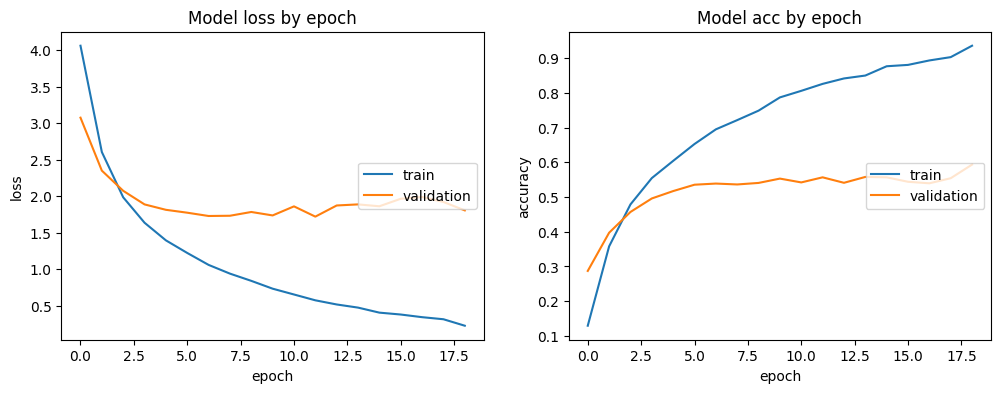

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp4.h5')